# 2.0 Exploratory Data Analysis

## Contents



In [3]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("eda") \
    .getOrCreate()

22/04/15 14:17:36 WARN Utils: Your hostname, paul-INTEL resolves to a loopback address: 127.0.1.1; using 192.168.1.199 instead (on interface wlp3s0)
22/04/15 14:17:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/15 14:17:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet("../data/edited/electronics*.parquet")
df.createOrReplaceTempView("electronics")

In [45]:
df.show()

+-------+--------+--------------+----------+--------------------+--------------------+--------------+
|overall|verified|    reviewerID|      asin|          reviewText|             summary|unixReviewTime|
+-------+--------+--------------+----------+--------------------+--------------------+--------------+
|      5|    true|A1N070NS9CJQ2I|0060009810|This was the firs...|       Hit The Spot!|    1026864000|
|      5|   false|A3P0KRKOBQK1KN|0060009810|As with all of Ms...|one hot summer is...|    1025913600|
|      5|   false|A192HO2ICJ75VU|0060009810|I've not read any...|      One Hot Summer|    1025654400|
|      4|   false|A2T278FKFL3BLT|0060009810|This romance nove...|   I love this book!|    1025395200|
|      5|   false|A2ZUXVTW8RXBXW|0060009810|Carolina Garcia A...|        One Hot Book|    1025222400|
|      4|   false|A21JDG4HA6OLPF|0060009810|Not only can she ...|Carolina does it ...|    1024963200|
|      5|   false|A2NCADLQY962YD|0060009810|Once again Garcia...|It's no mystery, 

In [138]:
df.select("overall").summary().show()

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|          20994353|
|   mean| 4.073685099988554|
| stddev|1.3857918282072794|
|    min|                 1|
|    25%|                 4|
|    50%|                 5|
|    75%|                 5|
|    max|                 5|
+-------+------------------+



In [147]:
time = df.select("unixReviewTime").summary().toPandas()

In [148]:
time

,summary,unixReviewTime
0,count,20994353
1,mean,1.4259668527545097E9
2,stddev,7.769205559499013E7
3,min,881193600
4,25%,1394064000
5,50%,1440633600
6,75%,1478736000
7,max,1538697600


In [149]:
time["unixReviewTime"] = pd.to_datetime(time['unixReviewTime'], unit='s')

In [156]:
time_subset = spark.sql("SELECT unixReviewTime FROM electronics LIMIT 1000").toPandas()

In [157]:
pd.to_datetime(time_subset['unixReviewTime'], unit='s')

0     2002-07-17
1     2002-07-06
2     2002-07-03
3     2002-06-30
4     2002-06-28
         ...    
995   2014-05-08
996   2014-05-07
997   2014-05-05
998   2014-05-05
999   2014-05-03
Name: unixReviewTime, Length: 1000, dtype: datetime64[ns]

In [5]:
df.createOrReplaceTempView("electronics")

In [136]:
spark.sql("""
SELECT
  summary
FROM
  electronics
WHERE
  summary like '%One Star%'
GROUP BY summary
""").show()

+--------------------+
|             summary|
+--------------------+
|One Star, HORRIBL...|
|One Star For the ...|
|           One Stars|
|One Star because ...|
|One Star - DIDN'T...|
|Read the One Star...|
|Deserves Just One...|
|Does Not Even Des...|
|One Star is  one ...|
|Doesn't Even dese...|
|Make sure to read...|
|A Five Star Radio...|
| One Star for lying!|
|Far Below One Sta...|
|           One Star.|
|One Star for Comp...|
|            One Star|
|  Less Than One Star|
|   One Star Per Port|
|If I Could Give L...|
+--------------------+
only showing top 20 rows



In [6]:
spark.sql("""SELECT 
               COUNT(overall), 
               overall 
            FROM electronics 
            WHERE verified=true 
            GROUP BY overall 
            ORDER BY overall DESC""").show()

+--------------+-------+
|count(overall)|overall|
+--------------+-------+
|      11381807|      5|
|       2889442|      4|
|       1338190|      3|
|        969462|      2|
|       2018191|      1|
+--------------+-------+



Count by Stars: verified purchases only


<AxesSubplot:xlabel='overall'>

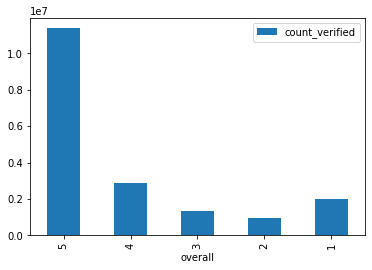

In [107]:
print("Count by Stars: verified purchases only")
spark.sql("""SELECT 
                COUNT(overall) as count_verified,  
                overall 
              FROM 
                electronics 
              WHERE 
                verified=true
              GROUP BY overall 
              ORDER BY overall DESC""").toPandas().plot.bar("overall")

Count by Stars: nonverified purchases only


<AxesSubplot:xlabel='overall'>

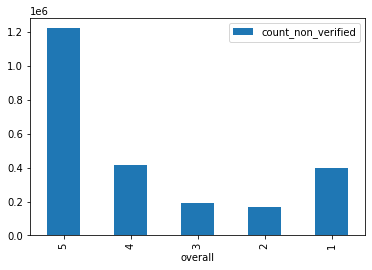

In [110]:
print("Count by Stars: nonverified purchases only")
spark.sql("""SELECT 
                COUNT(overall) as count_non_verified,  
                overall 
              FROM 
                electronics 
              WHERE 
                verified=false
              GROUP BY overall 
              ORDER BY overall DESC""").toPandas().plot.bar("overall")

In [117]:
verified = spark.sql("""
SELECT 
  COUNT(verified), overall as Review_Stars
FROM
  electronics
GROUP BY 
  overall, verified
ORDER BY
  overall, verified
            """).toPandas()

In [167]:
spark.sql("""
SELECT
  reviewText
FROM
  electronics
WHERE
  overall=5""")

ConnectionRefusedError: [Errno 111] Connection refused

In [173]:
spark.stop()

ConnectionRefusedError: [Errno 111] Connection refused